In [1]:
#import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import random

from tensorflow import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import*
from keras.optimizers import Adam

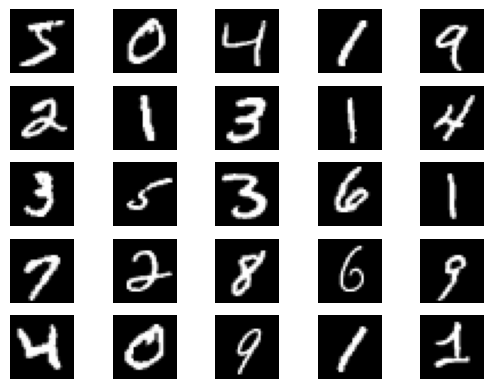

In [2]:
#load mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

n_samples = 25
#look at the samples of mnist
for i in range(n_samples):
    plt.subplot(5, 5, 1 + i)
    plt.axis('off')
    plt.imshow(x_train[i], cmap='gray')
plt.show()

# Models

In [3]:
#define discriminator model
def define_discriminator():
    discriminator = Sequential([
    Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=(28,28,1)),
    LeakyReLU(alpha=0.2),
    Dropout(0.4),
    
    Conv2D(64, (3,3), strides=(2, 2), padding='same'),
    LeakyReLU(alpha=0.2),
    Dropout(0.4),
    
    Flatten(),
    Dense(1, activation='sigmoid')
    ])
    
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
    return discriminator

#build discriminztor
d_model = define_discriminator()

#look at architecture of discriminator
d_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0

In [4]:
#define generator model
def define_generator(latent_dim):
    generator = Sequential([
    Dense(128 * 7 * 7, input_dim=latent_dim),
    LeakyReLU(alpha=0.2),
    Reshape((7, 7, 128)),
    
    Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'),
    LeakyReLU(alpha=0.2),
    
    Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'),
    LeakyReLU(alpha=0.2),
    Conv2D(1, (7,7), activation='sigmoid', padding='same')
    ])
    
    return generator

#set the constant
latent_dim = 100
#build generator
g_model = define_generator(latent_dim)
#look at architecture of generator
g_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      262272    
 ranspose)                                            

In [5]:
#define GAN model
def define_gan(g_model, d_model):
    d_model.trainable = False

    gan = Sequential()
    gan.add(g_model)
    gan.add(d_model)

    gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return gan

#create GAN
gan_model = define_gan(g_model, d_model)
#look at GAN architecture
gan_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 28, 28, 1)         1164289   
                                                                 
 sequential (Sequential)     (None, 1)                 40705     
                                                                 
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


# Helping Functions

In [11]:
#function which load and preprocess train samples
def load_real_samples():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = np.expand_dims(x_train / 255, axis=-1).astype('float32')
    return x_train

#function which select random samples from train samples
def select_real_samples(dataset, quantity):
    selected_indexes = [random.randint(0, len(dataset) - 1) for _ in range(quantity)]
    selected_samples = dataset[selected_indexes]
    label_real = np.ones((quantity, 1))
    return selected_samples, label_real

#function which generate points in latent space
def generate_latent_points(latent_dim, n_samples):
    points = np.random.randn(latent_dim * n_samples)
    points = points.reshape(n_samples, latent_dim)
    return points

#function which generate fake samples
def generate_fake_samples(g_model, latent_dim, n_samples):
    points = generate_latent_points(latent_dim, n_samples)
    samples = g_model.predict(points)
    real_labels = np.zeros((n_samples, 1))
    return samples, real_labels

#function to display generated images
def show_images(examples, n):
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    plt.show()

# Training functions

In [12]:
#function to train discriminator
def train_discriminator(discriminator, dataset, epochs=50, batch=256):    
    for i in range(epochs):
        x_real, y_real = select_real_samples(dataset, batch)
        _, real_acc = discriminator.train_on_batch(x_real, y_real)
        x_fake, y_fake = generate_fake_samples_for_discriminator(batch)
        _, fake_acc = discriminator.train_on_batch(x_fake, y_fake)
        
        print(f'>{i+1} \n accuracy_real={real_acc*100} \n accuracy_fake={fake_acc*100}')

In [13]:
#function to train GAN
def train(g_model, d_model, gan_model, dataset, latent_dim, epochs=100, batches=256):
    number_batches = int(dataset.shape[0] / batches)
    batches //= 2
    #training by epochs
    for i in range(epochs):
        #trainig by batches in epoch
        for j in range(number_batches):
            X_real, y_real = select_real_samples(dataset, batches)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, batches)
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            d_loss, _ = d_model.train_on_batch(X, y)
            X_gan = generate_latent_points(latent_dim, batches)
            y_gan = np.ones((batches, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            print(f'>{i+1}, {j+1}/{number_batches}, \n         disc loss={d_loss}, \n         gen loss={g_loss}')
        latent_points = generate_latent_points(100, 25)
        X = g_model.predict(latent_points)
        show_images(X, 5)

# Train models

4/4 [==============================] - 0s 41ms/step
>1, 1/234, 
         disc loss=0.2506929934024811, 
         gen loss=1.6540236473083496
4/4 [==============================] - 0s 40ms/step
>1, 2/234, 
         disc loss=0.2514111399650574, 
         gen loss=1.678934097290039
4/4 [==============================] - 0s 40ms/step
>1, 3/234, 
         disc loss=0.2396429479122162, 
         gen loss=1.706838607788086
4/4 [==============================] - 0s 37ms/step
>1, 4/234, 
         disc loss=0.224665105342865, 
         gen loss=1.7600642442703247
4/4 [==============================] - 0s 39ms/step
>1, 5/234, 
         disc loss=0.24348552525043488, 
         gen loss=1.7541602849960327
4/4 [==============================] - 0s 40ms/step
>1, 6/234, 
         disc loss=0.21349938213825226, 
         gen loss=1.7766237258911133
4/4 [==============================] - 0s 39ms/step
>1, 7/234, 
         disc loss=0.20897245407104492, 
         gen loss=1.8461146354675293
4/4 [========

4/4 [==============================] - 0s 39ms/step
>1, 59/234, 
         disc loss=0.09638470411300659, 
         gen loss=2.1360177993774414
4/4 [==============================] - 0s 41ms/step
>1, 60/234, 
         disc loss=0.1005830317735672, 
         gen loss=2.167696475982666
4/4 [==============================] - 0s 39ms/step
>1, 61/234, 
         disc loss=0.10272741317749023, 
         gen loss=2.166025161743164
4/4 [==============================] - 0s 41ms/step
>1, 62/234, 
         disc loss=0.09468045830726624, 
         gen loss=2.1992263793945312
4/4 [==============================] - 0s 42ms/step
>1, 63/234, 
         disc loss=0.09700550138950348, 
         gen loss=2.2063956260681152
4/4 [==============================] - 0s 41ms/step
>1, 64/234, 
         disc loss=0.0910058319568634, 
         gen loss=2.1784939765930176
4/4 [==============================] - 0s 42ms/step
>1, 65/234, 
         disc loss=0.09480676054954529, 
         gen loss=2.1657400131225586
4/4

>1, 116/234, 
         disc loss=0.0473208874464035, 
         gen loss=3.1624951362609863
4/4 [==============================] - 0s 41ms/step
>1, 117/234, 
         disc loss=0.04767385125160217, 
         gen loss=3.167553424835205
4/4 [==============================] - 0s 39ms/step
>1, 118/234, 
         disc loss=0.04102814197540283, 
         gen loss=3.150137424468994
4/4 [==============================] - 0s 40ms/step
>1, 119/234, 
         disc loss=0.04153990000486374, 
         gen loss=3.1868929862976074
4/4 [==============================] - 0s 40ms/step
>1, 120/234, 
         disc loss=0.03693818300962448, 
         gen loss=3.1824288368225098
4/4 [==============================] - 0s 41ms/step
>1, 121/234, 
         disc loss=0.038453616201877594, 
         gen loss=3.1950674057006836
4/4 [==============================] - 0s 41ms/step
>1, 122/234, 
         disc loss=0.039589110761880875, 
         gen loss=3.182206869125366
4/4 [==============================] - 0s 39ms

4/4 [==============================] - 0s 39ms/step
>1, 174/234, 
         disc loss=0.018908299505710602, 
         gen loss=3.717825174331665
4/4 [==============================] - 0s 38ms/step
>1, 175/234, 
         disc loss=0.02559548057615757, 
         gen loss=3.75314998626709
4/4 [==============================] - 0s 41ms/step
>1, 176/234, 
         disc loss=0.021708965301513672, 
         gen loss=3.7440459728240967
4/4 [==============================] - 0s 41ms/step
>1, 177/234, 
         disc loss=0.023022374138236046, 
         gen loss=3.754298686981201
4/4 [==============================] - 0s 41ms/step
>1, 178/234, 
         disc loss=0.02217157930135727, 
         gen loss=3.7525296211242676
4/4 [==============================] - 0s 43ms/step
>1, 179/234, 
         disc loss=0.021900391206145287, 
         gen loss=3.748795509338379
4/4 [==============================] - 0s 41ms/step
>1, 180/234, 
         disc loss=0.019437594339251518, 
         gen loss=3.756362438

4/4 [==============================] - 0s 42ms/step
>1, 231/234, 
         disc loss=0.010636692866683006, 
         gen loss=4.197600364685059
4/4 [==============================] - 0s 40ms/step
>1, 232/234, 
         disc loss=0.010976008139550686, 
         gen loss=4.189892292022705
4/4 [==============================] - 0s 40ms/step
>1, 233/234, 
         disc loss=0.013053259812295437, 
         gen loss=4.236909866333008
4/4 [==============================] - 0s 41ms/step
>1, 234/234, 
         disc loss=0.010842841118574142, 
         gen loss=4.225696563720703
1/1 [==============================] - 0s 94ms/step


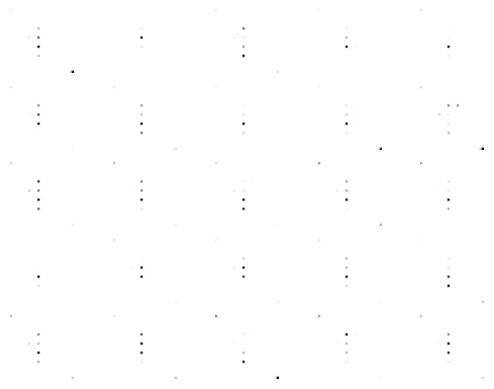

4/4 [==============================] - 0s 44ms/step
>2, 1/234, 
         disc loss=0.009055317379534245, 
         gen loss=4.243716239929199
4/4 [==============================] - 0s 41ms/step
>2, 2/234, 
         disc loss=0.014250664040446281, 
         gen loss=4.226987838745117
4/4 [==============================] - 0s 41ms/step
>2, 3/234, 
         disc loss=0.01830967888236046, 
         gen loss=4.261264801025391
4/4 [==============================] - 0s 40ms/step
>2, 4/234, 
         disc loss=0.01190400030463934, 
         gen loss=4.2926530838012695
4/4 [==============================] - 0s 38ms/step
>2, 5/234, 
         disc loss=0.011752402409911156, 
         gen loss=4.281800746917725
4/4 [==============================] - 0s 42ms/step
>2, 6/234, 
         disc loss=0.013347478583455086, 
         gen loss=4.294246673583984
4/4 [==============================] - 0s 39ms/step
>2, 7/234, 
         disc loss=0.011598585173487663, 
         gen loss=4.310809135437012
4/4 [==

4/4 [==============================] - 0s 41ms/step
>2, 59/234, 
         disc loss=0.021751530468463898, 
         gen loss=3.8402087688446045
4/4 [==============================] - 0s 41ms/step
>2, 60/234, 
         disc loss=0.019975537434220314, 
         gen loss=3.930410385131836
4/4 [==============================] - 0s 40ms/step
>2, 61/234, 
         disc loss=0.016265664249658585, 
         gen loss=3.994649887084961
4/4 [==============================] - 0s 41ms/step
>2, 62/234, 
         disc loss=0.021516526117920876, 
         gen loss=3.995938539505005
4/4 [==============================] - 0s 44ms/step
>2, 63/234, 
         disc loss=0.024383436888456345, 
         gen loss=3.8837084770202637
4/4 [==============================] - 0s 41ms/step
>2, 64/234, 
         disc loss=0.05060933157801628, 
         gen loss=3.5888710021972656
4/4 [==============================] - 0s 42ms/step
>2, 65/234, 
         disc loss=0.19693519175052643, 
         gen loss=3.42319393157959

4/4 [==============================] - 0s 40ms/step
>2, 117/234, 
         disc loss=0.6114307641983032, 
         gen loss=0.9652662873268127
4/4 [==============================] - 0s 45ms/step
>2, 118/234, 
         disc loss=0.5983770489692688, 
         gen loss=0.9251226186752319
4/4 [==============================] - 0s 40ms/step
>2, 119/234, 
         disc loss=0.5833379626274109, 
         gen loss=0.9816293120384216
4/4 [==============================] - 0s 40ms/step
>2, 120/234, 
         disc loss=0.5841691493988037, 
         gen loss=0.9553130865097046
4/4 [==============================] - 0s 38ms/step
>2, 121/234, 
         disc loss=0.5539739727973938, 
         gen loss=0.9869422912597656
4/4 [==============================] - 0s 41ms/step
>2, 122/234, 
         disc loss=0.5478115081787109, 
         gen loss=1.0046863555908203
4/4 [==============================] - 0s 38ms/step
>2, 123/234, 
         disc loss=0.5520043969154358, 
         gen loss=1.0856926441192627

4/4 [==============================] - 0s 45ms/step
>2, 175/234, 
         disc loss=0.696308970451355, 
         gen loss=0.7979965209960938
4/4 [==============================] - 0s 38ms/step
>2, 176/234, 
         disc loss=0.6789219379425049, 
         gen loss=0.8732051253318787
4/4 [==============================] - 0s 38ms/step
>2, 177/234, 
         disc loss=0.7110437750816345, 
         gen loss=0.7764194011688232
4/4 [==============================] - 0s 41ms/step
>2, 178/234, 
         disc loss=0.6980339288711548, 
         gen loss=0.7703434228897095
4/4 [==============================] - 0s 38ms/step
>2, 179/234, 
         disc loss=0.6841254234313965, 
         gen loss=0.846747875213623
4/4 [==============================] - 0s 41ms/step
>2, 180/234, 
         disc loss=0.7002154588699341, 
         gen loss=0.8188157081604004
4/4 [==============================] - 0s 39ms/step
>2, 181/234, 
         disc loss=0.668480634689331, 
         gen loss=0.853408694267273
4/4

4/4 [==============================] - 0s 40ms/step
>2, 233/234, 
         disc loss=0.7233670353889465, 
         gen loss=0.7366175651550293
4/4 [==============================] - 0s 43ms/step
>2, 234/234, 
         disc loss=0.7341499328613281, 
         gen loss=0.7597131729125977
1/1 [==============================] - 0s 31ms/step


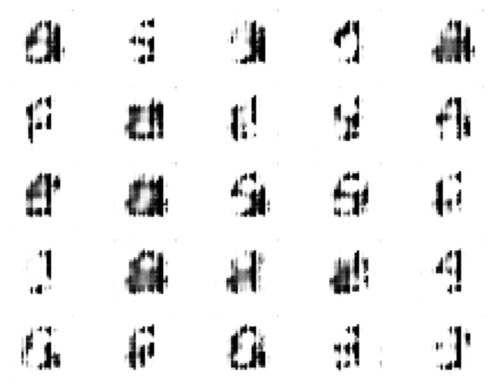

4/4 [==============================] - 0s 39ms/step
>3, 1/234, 
         disc loss=0.7283024787902832, 
         gen loss=0.7318763136863708
4/4 [==============================] - 0s 41ms/step
>3, 2/234, 
         disc loss=0.7308024168014526, 
         gen loss=0.7730731964111328
4/4 [==============================] - 0s 41ms/step
>3, 3/234, 
         disc loss=0.6843276023864746, 
         gen loss=0.7720416784286499
4/4 [==============================] - 0s 43ms/step
>3, 4/234, 
         disc loss=0.6939334869384766, 
         gen loss=0.8068639039993286
4/4 [==============================] - 0s 41ms/step
>3, 5/234, 
         disc loss=0.6948964595794678, 
         gen loss=0.7679046988487244
4/4 [==============================] - 0s 46ms/step
>3, 6/234, 
         disc loss=0.6974939107894897, 
         gen loss=0.777633547782898
4/4 [==============================] - 0s 46ms/step
>3, 7/234, 
         disc loss=0.674752950668335, 
         gen loss=0.8145804405212402
4/4 [==========

KeyboardInterrupt: 

In [14]:
#loading data
dataset = load_real_samples()
#train GAN
train(g_model, d_model, gan_model, dataset, latent_dim)

# Look at results

1/1 [==============================] - 0s 42ms/step


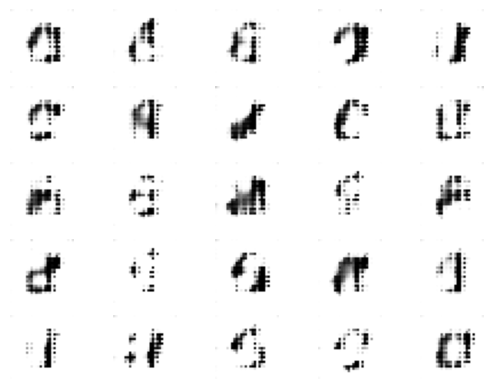

In [20]:
latent_points = generate_latent_points(100, 25)
X = g_model.predict(latent_points)
show_images(X, 5)